# Naive Bayesian Model implementation

In this notebook, we implement two Gaussian Naive Bayesian models using two kinds of features:
- **tf-idf** vectorized features.
- **hasing-vectorize** features.

For each model, we first build model on given constant and then using tunning to choose the most approriate hyperameters.

### Load dataset

In [1]:
import sys
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
# import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from data import Preprocessing
from visualization import plot_roc_auc, plot_confusion_matrix, compute_f1_score
from dimension_reduction import PCA, WordEmbeddingVectors

# Define constants
MAX_FEATURES = 1000
MAX_GRAMS = 3
MIN_GRAMS = 1
N_FEATURES = 1000

### Study dataset

In [2]:
prepro = Preprocessing()

train_df = prepro.read_CSV('train.csv')
test_df = prepro.read_CSV('test.csv')

train_df.info()

✓ 'punkt' is already available.
✓ 'stopwords' is already available.
✗ 'wordnet' not found. Downloading...
✓ 'averaged_perceptron_tagger' is already available.
<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             27480 non-null  object 
 1   text               27480 non-null  object 
 2   selected_text      27480 non-null  object 
 3   sentiment          27480 non-null  object 
 4   Time of Tweet      27480 non-null  object 
 5   Age of User        27480 non-null  object 
 6   Country            27480 non-null  object 
 7   Population -2020   27480 non-null  int64  
 8   Land Area (Kmï¿½)  27480 non-null  float64
 9   Density (P/Kmï¿½)  27480 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ MB


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tranquochieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preproccessing

### Convert `sentiment` to column label

In [3]:
train_df['text'] = train_df['text'].apply(lambda x: prepro.tokenize_preprocessing(x, False))
test_df['text'] = test_df['text'].apply(lambda x: prepro.tokenize_preprocessing(x, False))

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['sentiment'])
test_df['label'] = le.transform(test_df['sentiment'])

train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Kmï¿½),Density (P/Kmï¿½),label
0,cb774db0d1,id responded going,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,1
1,549e992a42,sooo sad miss san diego,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,0
2,088c60f138,bos bullying,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,0
3,9642c003ef,interview leave alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,0
4,358bd9e861,son couldnt put release already bought,"Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,0


# B. Construct Gaussian NB model with Tf-idf vector

## 1. Build sample model

### Vectorize the column `text`

In [64]:

tfidf = TfidfVectorizer(ngram_range=(1,MAX_GRAMS), max_features=MAX_FEATURES)
tfidf.fit(train_df['text'])

X_train = tfidf.transform(train_df['text'])
X_test = tfidf.transform(test_df['text'])

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Prepare data

In [65]:
X_train = X_train.toarray()
X_test = X_test.toarray()

y_train = train_df['label']
y_test = test_df['label']
X_train.shape, y_train.shape

((27480, 1000), (27480,))

### Fitting model and evaluation

F1 score:  0.5068359314370995
Accuracy score:  0.522354272778721


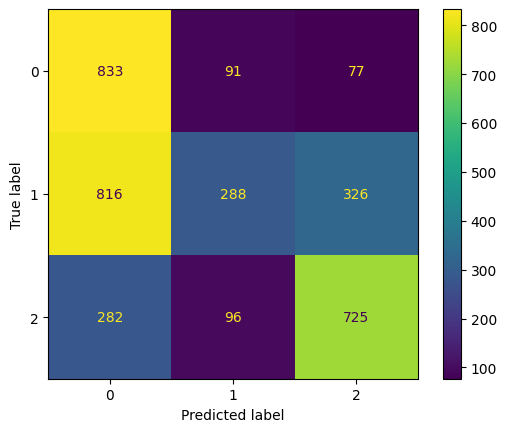

In [66]:
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("F1 score: ", compute_f1_score(y_test, y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

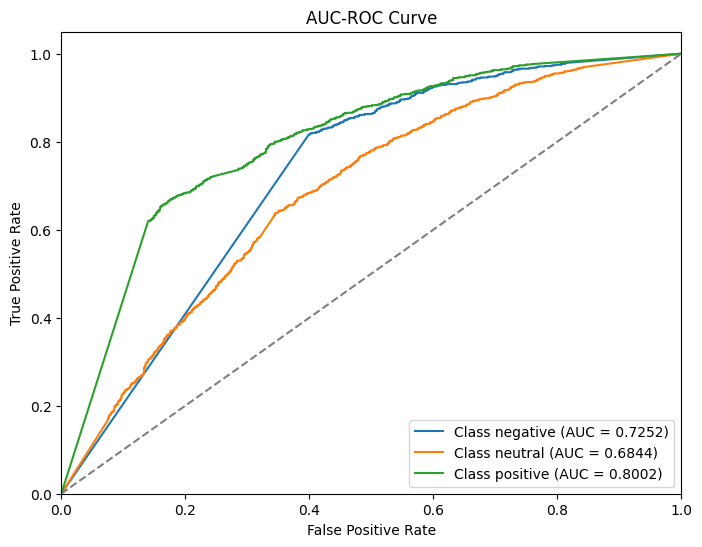

In [55]:
y_prob = model.predict_proba(X_test)
plot_roc_auc(y_test, y_prob, classes=le.classes_)

## 2. Using PCA

In [8]:
pca = PCA()

pca.fit_by_amount_of_variance(X_train, threshold=0.6)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train.shape, X_train_pca.shape

PCA keep 485 components correponding to keep 0.600121426495173 of total variance


((27480, 1000), (27480, 485))

### Fit model

F1 score:  0.438907606471775
Accuracy score:  0.44368986983588005


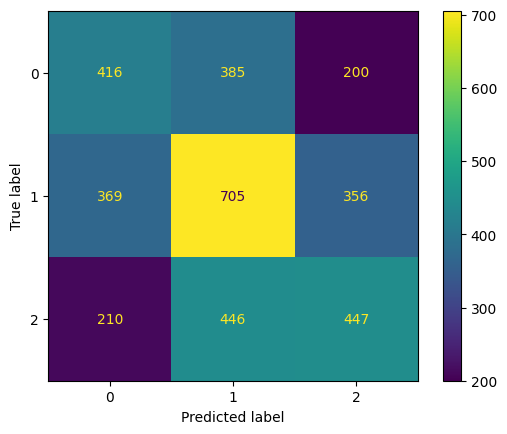

In [9]:
model = GaussianNB()
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

print("F1 score: ", compute_f1_score(y_test, y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

## 3. Hyperparamater Tunning

### Split into validation dataframe

In [10]:
from sklearn.model_selection import train_test_split

hyper_train_df, val_df = train_test_split(train_df, test_size=0.11, random_state=42)            # val_df have sane size with test_df
hyper_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24457 entries, 1291 to 23655
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             24457 non-null  object 
 1   text               24457 non-null  object 
 2   selected_text      24457 non-null  object 
 3   sentiment          24457 non-null  object 
 4   Time of Tweet      24457 non-null  object 
 5   Age of User        24457 non-null  object 
 6   Country            24457 non-null  object 
 7   Population -2020   24457 non-null  int64  
 8   Land Area (Kmï¿½)  24457 non-null  float64
 9   Density (P/Kmï¿½)  24457 non-null  int64  
 10  label              24457 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 2.2+ MB


### Tunning

In [11]:
from hyperparameter_tunning import *
from sklearn.feature_extraction.text import TfidfVectorizer

# Construct suggestion instances
tunning_params = [
    IntVariableSuggestion("max_features", 1000, 5000),
    IntVariableSuggestion("max_grams", 2, 3),
    FloatVariableSuggestion("pca_var_amount", 0.3, 0.8)
]

def training_func(train_df, tfidf_max_features, tfidf_max_grams, pca_threshold):
    nb_model = GaussianNB()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,tfidf_max_grams), max_features=tfidf_max_features)
    scaler = StandardScaler(with_mean=False)
    pca = PCA()

    X_train = tfidf_vectorizer.fit_transform(train_df['text'])
    X_train = scaler.fit_transform(X_train).toarray()
    
    print("Shape: ", X_train.shape)

    pca.fit_by_amount_of_variance(X_train, threshold=pca_threshold)
    X_train_pca = pca.transform(X_train)

    nb_model.fit(X_train_pca, train_df['label'])

    models = {
        "tf_idf": tfidf_vectorizer,
        "scaler": scaler,
        "pca": pca,
        "model": nb_model,
    }

    return models

def evaluation_func(models, test_df):
    X_test = models['tf_idf'].transform(test_df['text'])

    X_test = models['scaler'].transform(X_test).toarray()
    X_test_pca = models['pca'].transform(X_test)

    y_pred = models['model'].predict(X_test_pca)

    return compute_f1_score(y_pred=y_pred, y_true=test_df['label'])

tunning_model = Tunning(tunning_params, training_func, evaluation_func)
study = tunning_model.tunning(hyper_train_df, val_df, n_trials=2, direction='maximize', timeout=None)

[I 2025-05-18 21:03:20,095] A new study created in memory with name: no-name-f76669ca-dff8-4e25-bafe-d1dfde5a52b0


Shape:  (24457, 1569)
PCA keep 937 components correponding to keep 0.7228946438909059 of total variance


[I 2025-05-18 21:04:20,655] Trial 0 finished with value: 0.38204567954745405 and parameters: {'max_features': 1569, 'max_grams': 3, 'pca_var_amount': 0.7228295236670632}. Best is trial 0 with value: 0.38204567954745405.


Shape:  (24457, 3524)
PCA keep 1029 components correponding to keep 0.4434576232983129 of total variance


[I 2025-05-18 21:06:47,519] Trial 1 finished with value: 0.3769950291661352 and parameters: {'max_features': 3524, 'max_grams': 2, 'pca_var_amount': 0.44312800270190517}. Best is trial 0 with value: 0.38204567954745405.


In [20]:
max_features, max_grams, pca_threshold = study.best_params.values()
print(f"max_features: {max_features}, max_grams: {max_grams} and NB var smoothing: {pca_threshold}")

nb_model = GaussianNB()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, max_grams), max_features=max_features)
scaler = StandardScaler(with_mean=False)
pca = PCA()

X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_train = scaler.fit_transform(X_train).toarray()

# Create PCA
pca.fit_by_amount_of_variance(X_train, threshold=pca_threshold)
X_train_pca = pca.transform(X_train)

X_test = tfidf_vectorizer.transform(test_df['text'])
X_test = scaler.transform(X_test).toarray()
X_test_pca = pca.transform(X_test)

# Fit model
nb_model.fit(X_train_pca, train_df['label'])

max_features: 1569, max_grams: 3 and NB var smoothing: 0.7228295236670632
PCA keep 944 components correponding to keep 0.7231509037174957 of total variance


GaussianNB()

### Testing in `test_df`

In [21]:
max_features, max_grams, pca_threshold

(1569, 3, 0.7228295236670632)

Accuracy score:  0.4052065647990945
F1 score:  0.40515591775567167


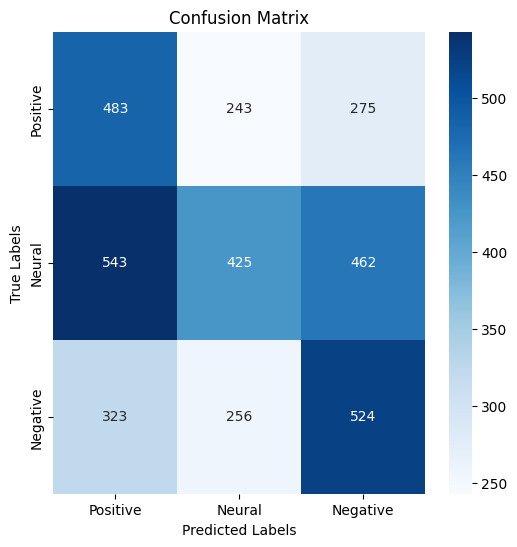

In [22]:
y_pred = nb_model.predict(X_test_pca)
y_test = test_df['label']

print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1 score: ", compute_f1_score(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, class_labels=["Positive", "Neural", "Negative"])

### Plot AUC-ROC Curve

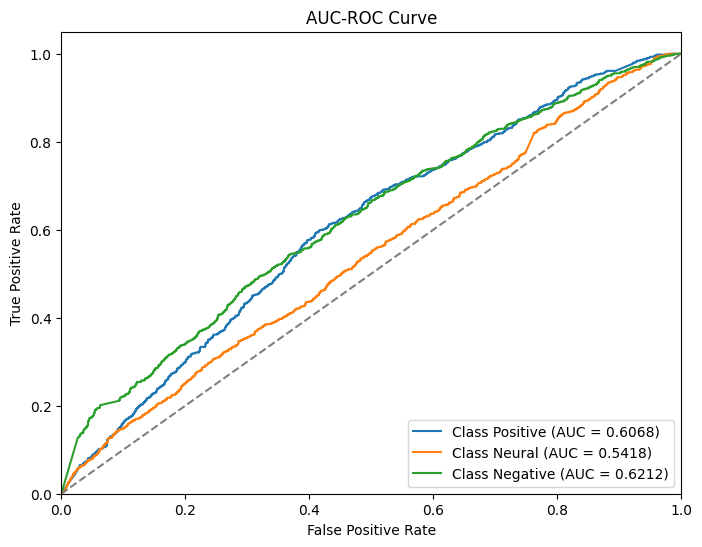

In [25]:
y_pred_prob = nb_model.predict_proba(X_test_pca)

plot_roc_auc(y_test, y_pred_prob, classes=["Positive", "Neural", "Negative"])

# B. Using word embedding vectors

In [56]:
model = WordEmbeddingVectors()

X_train_embedding = model.vectorize(train_df['text'])
X_test_embedding = model.vectorize(test_df['text'])

y_train = train_df['label']
y_test = test_df['label']

X_train_embedding.shape

/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/.DS_Store
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/test.csv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/fasttext_subwords_300.kv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/train.csv
/Users/tranquochieu/Documents/Pycharm project/ML_Cabapyra_new/data/fasttext_subwords_300.kv.vectors.npy
Loader model successfully ! Vector size: 300


(27480, 300)

### Train and Evaluate model

In [57]:
model = GaussianNB()
model.fit(X_train_embedding, y_train)
model

GaussianNB()

F1 score:  0.5331825951023416
Accuracy score:  0.5350877192982456


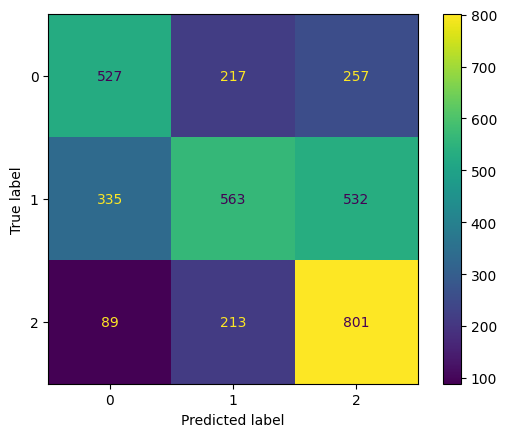

In [59]:
y_pred = model.predict(X_test_embedding)

print("F1 score: ", compute_f1_score(y_test, y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

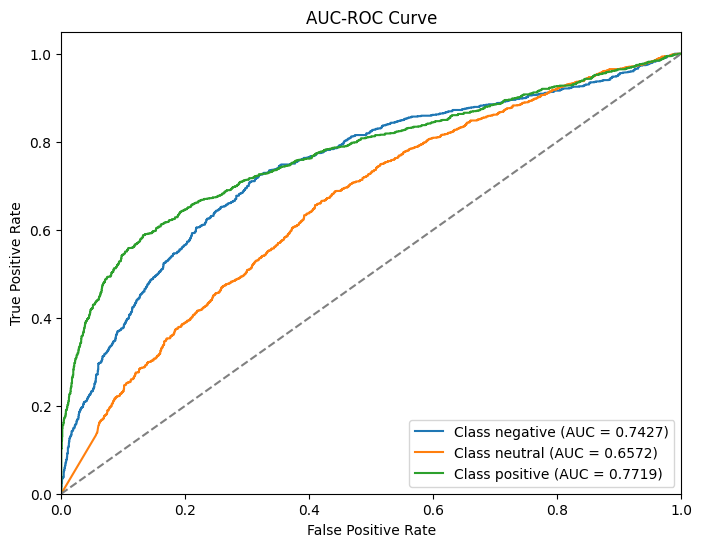

In [60]:
y_prob = model.predict_proba(X_test_embedding)
plot_roc_auc(y_test, y_prob, le.classes_)

## 2. Use PCA

In [48]:
pca = PCA()
pca.fit_by_fix_features(X_train_embedding, top_k=20)
X_train_pca = pca.transform(X_train_embedding)
X_test_pca = pca.transform(X_test_embedding)
X_train_pca.shape

Amount of variance after reducing:  0.5347295314749411


(27480, 20)

In [49]:
model = GaussianNB()
model.fit(X_train_pca, y_train)
model

GaussianNB()

F1 score:  0.5969222164356623
Accuracy score:  0.597623089983022


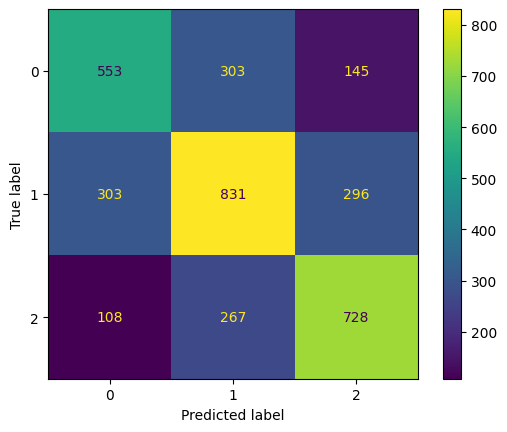

In [50]:
y_pred = model.predict(X_test_pca)

print("F1 score: ", compute_f1_score(y_test, y_pred))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

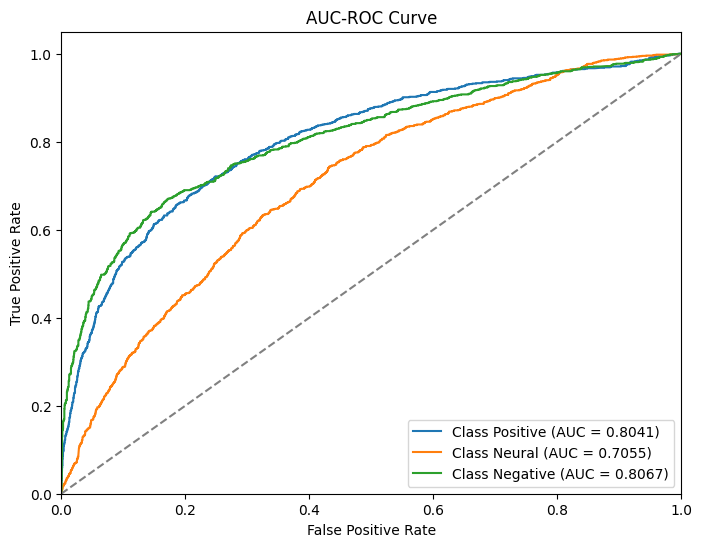

In [47]:
y_pred_prob = model.predict_proba(X_test_pca)

plot_roc_auc(y_test, y_pred_prob, classes=["Positive", "Neural", "Negative"])